# Objective

#### Given a review determine whether a review is negative or positive using Navie bayes ,  and find the optimal value of alpha such that our model should not overfit or underfit

In [1]:
#importing the required packages
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = sqlite3.connect('./database.sqlite') #connecting with the sql



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 because 3 can be cosidered as a neutral
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.head(5)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
import datetime
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#deduplication
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Helpfulness numerator is always less than or equal to the helpfulness denominator so we have to remove it
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [9]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
final.shape

(364171, 10)

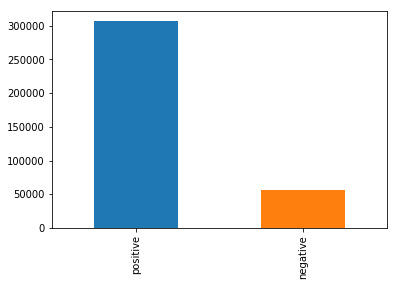

In [11]:
final['Score'].value_counts().plot(kind='bar')

# TEXT PREPROCESSING

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'those', 'having', 'are', 'needn', 'too', 'and', 'themselves', 'shan', 'whom', 'my', 'her', 'they', 'i', 'doing', 'out', 'can', 'itself', 'be', 'you', 'with', 'under', 'these', 'been', 'haven', 'the', 'herself', "couldn't", "isn't", 'its', 'don', 'shouldn', "weren't", 'will', 'yourselves', "shan't", 'ourselves', 'their', 'being', 'yourself', 'other', 'doesn', 'over', 'a', 'or', 'only', "you'll", 'after', 'were', 'himself', 'isn', 'your', "it's", 'as', 'while', 'how', 'into', 'some', "hasn't", "haven't", "shouldn't", 's', 'hadn', 'all', 'very', 'did', "that'll", 'won', 'here', "mustn't", 'now', 've', "needn't", 'him', "should've", 'y', 'to', 'then', 'each', 're', 'them', 'during', 'me', 'it', 'own', 'ain', "mightn't", 'below', 'hasn', 'there', 'why', 'do', "you've", 'by', 'because', 'against', "wouldn't", 'wouldn', "wasn't", 'further', 'of', "hadn't", 'if', 'more', 'not', 'm', 'have', 'above', 'was', 'weren', 'who', 'which', 'am', 'through', 'in', 'no', 'ma', 'for', 'between', 'but', '

In [13]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
final['CleanedText']=final_string

In [18]:
final=final.reset_index(drop=True)
final.shape

(364171, 11)

In [19]:
final_train=final['CleanedText']    

# Navie bayes with BAG OF WORDS

In [20]:
import math
from sklearn import datasets
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X = final_train
y = final['Score']

X_train =  final_train[:math.ceil(len(final)*.7)] 
X_test = final_train[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [21]:
count_vect = CountVectorizer() 
final_x = count_vect.fit_transform(X_train)
final_x.shape

(254920, 59199)

In [23]:
X_test=count_vect.transform(X_test)

In [24]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
myList = list(np.arange(0.00001, 0.001, 0.00005))


# empty list that will hold cv scores
cv_scores = []
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(final_x, y_train, test_size=0.3)

# perform 10-fold cross validation
for i in myList:
    nb = MultinomialNB(alpha = i)
    model = nb.fit(X_tr, y_tr)
    
    # predict the response on the crossvalidation train
    pred = model.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True)
    cv_scores.append(acc)
     

# changing to misclassification error
MSE = [1 - x for x in cv_scores]




In [25]:
# determining best alpha
optimal_alpha = myList[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is {}'  .format(optimal_alpha))


The optimal value of alpha is 0.00096


the misclassification error for each alpha value is :  [0.10667 0.10597 0.10565 0.10543 0.1053  0.10517 0.10516 0.1051  0.10504
 0.10504 0.10496 0.10491 0.1048  0.10474 0.10462 0.10456 0.10449 0.10444
 0.1044  0.10437]


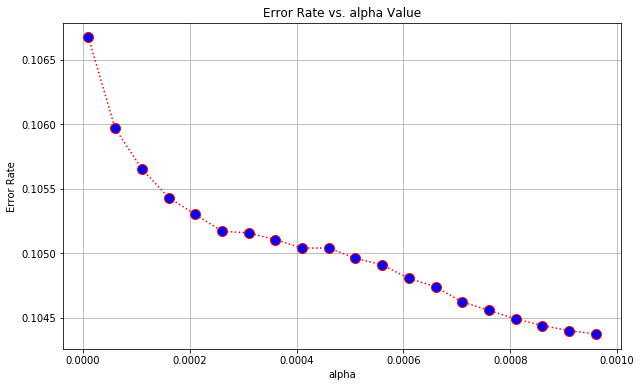

In [26]:
plt.figure(figsize=(10,6))
plt.plot(myList,MSE,color='red', linestyle='dotted', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. alpha Value')
plt.xlabel('alpha')
plt.ylabel('Error Rate')
plt.grid()
print("the misclassification error for each alpha value is : ", np.round(MSE,5))
    

In [27]:
from sklearn.metrics import accuracy_score   
nb =  MultinomialNB(alpha = optimal_alpha)#initializing MultinomialNB to the varible nb
nb.fit(final_x,y_train)#applying fit method to our training set
pred = nb.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)#calculating accuracy
print('\n****Test accuracy for alpha =optimal_alpha is %d%%' % (acc))


****Test accuracy for alpha =optimal_alpha is 88%


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


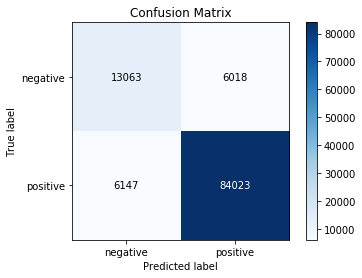

In [28]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,pred)

In [29]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.68      0.68      0.68     19081
   positive       0.93      0.93      0.93     90170

avg / total       0.89      0.89      0.89    109251



### Feature Importance

In [30]:
bow_feature = count_vect.get_feature_names()
df = pd.DataFrame(model.feature_log_prob_,columns=bow_feature)
df1_transposed = df.T
df1_transposed.head(3)

,0,1
aa,-20.855550,-14.864658
aaa,-13.906014,-12.513717
aaaa,-20.855550,-22.506863


In [31]:
bow_neg = df1_transposed[0].sort_values(ascending = False)[0:10] ##Negative
bow_pos =df1_transposed[1].sort_values(ascending = False)[0:10] ##Positive

### Top 10 words in Negative reviews having high probability

In [32]:
bow_neg

tast      -4.199318
like      -4.278646
product   -4.456593
one       -4.722874
flavor    -4.771356
tri       -4.870153
would     -4.872893
good      -5.039827
use       -5.062637
coffe     -5.084798
Name: 0, dtype: float64

### Top 10 words in positive reviews having high probabilty

In [33]:
bow_pos

like      -4.436612
tast      -4.504384
good      -4.642815
flavor    -4.663233
love      -4.688537
great     -4.714712
use       -4.733818
one       -4.792794
product   -4.879126
tea       -4.885037
Name: 1, dtype: float64

In [34]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y_bow = label_binarize(y_test, classes= ["negative","positive","x"])[:,:-1]
n_classes = y_bow.shape[1]
predbowprob = model.predict_proba(X_test)

In [35]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bow[:, i], predbowprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bow.ravel(), predbowprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

from scipy import interp
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

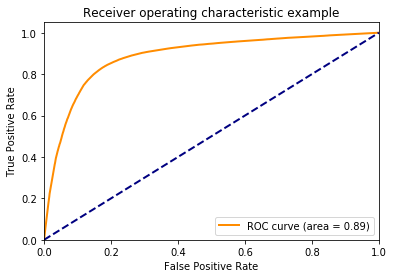

In [36]:
plt.figure()
lw = 2
plt.plot(fpr["macro"], tpr["macro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["macro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Naive bayes WITH TF-IDF

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
X = final_train
y = final['Score']

X_train =  final_train[:math.ceil(len(final)*.7)] 
X_test = final_train[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]
tf_idf_vec = TfidfVectorizer()#ngram_range=(2,2))

final_x = tf_idf_vec.fit_transform(X_train)

In [39]:
final_x.shape

(254920, 59199)

In [40]:
 X_test=tf_idf_vec.transform(X_test)

In [41]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
myList = list(np.arange(0.00001, 0.001, 0.00005))


# empty list that will hold cv scores
cv_scores = []
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(final_x, y_train, test_size=0.3)

# perform 10-fold cross validation
for i in myList:
    nb = MultinomialNB(alpha = i)
    model = nb.fit(X_tr, y_tr)
    
    # predict the response on the crossvalidation train
    pred = model.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True)
    cv_scores.append(acc)
     

# changing to misclassification error
MSE = [1 - x for x in cv_scores]




In [42]:
# determining best alpha
optimal_alpha = myList[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is {}'  .format(optimal_alpha))


The optimal value of alpha is 0.00096


the misclassification error for each alpha value is :  [0.12084 0.1204  0.12014 0.11993 0.11985 0.11979 0.11966 0.11953 0.11941
 0.11936 0.11933 0.11927 0.11925 0.11915 0.11911 0.11917 0.11908 0.11908
 0.11902 0.11895]


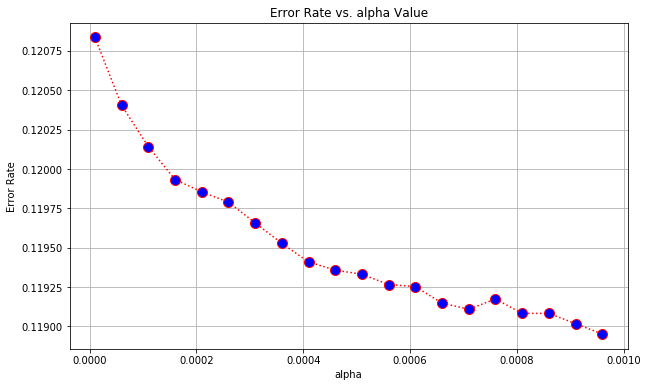

In [43]:
 plt.figure(figsize=(10,6))
plt.plot(myList,MSE,color='red', linestyle='dotted', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. alpha Value')
plt.xlabel('alpha')
plt.ylabel('Error Rate')
plt.grid()
print("the misclassification error for each alpha value is : ", np.round(MSE,5))

In [44]:
from sklearn.metrics import accuracy_score   
nb =  MultinomialNB(alpha = optimal_alpha)#initializing MultinomialNB to the varible nb
nb.fit(final_x,y_train)#applying fit method to our training set
pred = nb.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)#calculating accuracy
print('\n****Test accuracy for alpha =optimal_alpha is %d%%' % (acc))


****Test accuracy for alpha =optimal_alpha is 86%


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


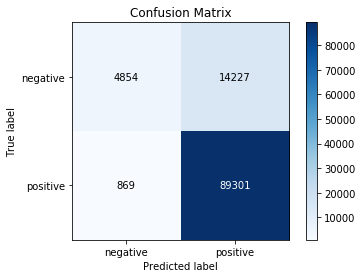

In [45]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,pred)

In [85]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.82      0.77      0.80      3810
   positive       0.76      0.82      0.79      3472

avg / total       0.79      0.79      0.79      7282



### feature importance

In [46]:
tf_feature = tf_idf_vec.get_feature_names()
df = pd.DataFrame(model.feature_log_prob_,columns=tf_feature)
df1_transposed = df.T
df1_transposed.head(3)

,0,1
aa,-18.703611,-20.417972
aaa,-13.268246,-12.910670
aaaa,-18.703611,-14.314293


In [47]:
tf_neg = df1_transposed[0].sort_values(ascending = False)[0:10] ##Negative
tf_pos =df1_transposed[1].sort_values(ascending = False)[0:10] ##Positive

### Top 10 words in Negative reviews having high probability

In [48]:
tf_neg

tast      -4.835753
like      -4.975037
product   -5.035408
would     -5.309576
flavor    -5.331500
coffe     -5.339703
one       -5.385434
tri       -5.457740
buy       -5.493347
order     -5.494799
Name: 0, dtype: float64

### Top 10 words in Posivite reviews having high probability

In [49]:
tf_pos

great     -5.061040
love      -5.078061
good      -5.139866
tast      -5.140774
like      -5.161175
tea       -5.171369
flavor    -5.213826
coffe     -5.247114
product   -5.313162
use       -5.332146
Name: 1, dtype: float64

In [50]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y_tf = label_binarize(y_test, classes= ["negative","positive","x"])[:,:-1]
n_classes = y_bow.shape[1]
predbowprob = model.predict_proba(X_test)

In [51]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_tf[:, i], predbowprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bow.ravel(), predbowprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

from scipy import interp
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

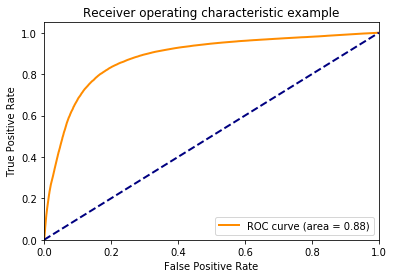

In [52]:
plt.figure()
lw = 2
plt.plot(fpr["macro"], tpr["macro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["macro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Accuracy measure with various vectorization technique:-
##### 1. With BAG of WORDS it is 88%
##### 2. With TF-IDF it is 86%
 

# Conclusion:-
### Amongst all the vectorization technique our BOW gives highest accuracy score .